 # **Importing Libraries**

In [ ]:
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Preprocessing**

 ## 1- Reading the folder pathes


In [ ]:
image_directory = '/content/drive/MyDrive/Brain_Tumor_Detection_MRI/Brain_Tumor_Detection/'
no_tumor_images = os.listdir(image_directory + 'no/')
yes_tumor_images = os.listdir(image_directory + 'yes/')


In [ ]:
no_tumor_count = len(no_tumor_images)
yes_tumor_count = len(yes_tumor_images)

print(f"Number of Normal MRI images : {no_tumor_count}")
print(f"Number of Tumor MRI images : {yes_tumor_count}")

Number of Normal MRI images : 1500
Number of Tumor MRI images : 1500


 ## 2- Visualize Dataset Images


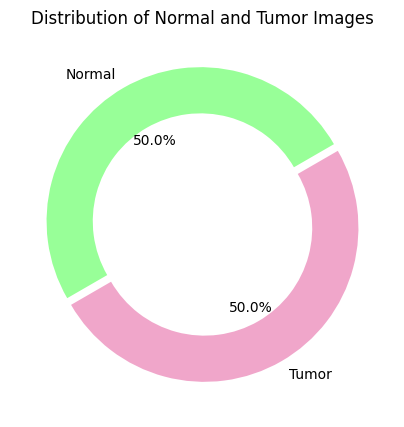

In [ ]:
labels = ['Normal', 'Tumor']
values = [no_tumor_count, yes_tumor_count]
colors = ['#98ff98', '#f0a6ca']
plt.figure(figsize=(5, 5))
plt.pie(values,
        labels=labels,
        colors=colors,
        autopct='%.1f%%',
        explode=(0.025, 0.025),
        startangle=30,
        wedgeprops=dict(width=0.3))
plt.title('Distribution of Normal and Tumor Images')


plt.show()

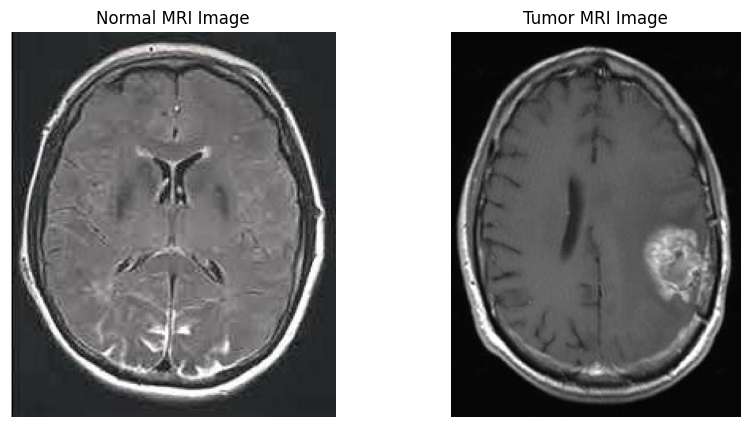

In [ ]:
normal_image_path = os.path.join(image_directory + 'no/', no_tumor_images[0])
tumor_image_path = os.path.join(image_directory + 'yes/', yes_tumor_images[0])

normal_image = cv2.imread(normal_image_path)
tumor_image = cv2.imread(tumor_image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(normal_image)
plt.title("Normal MRI Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(tumor_image)
plt.title("Tumor MRI Image")
plt.axis('off')
plt.show()

 ## 3- Loading , Preprocessing and Label Normal and Tumor MRI Images


In [ ]:
dataset = []
label = []

INPUT_SIZE = 64

for i, image_name in enumerate(no_tumor_images):
    if image_name.split('.')[1] == 'jpg':
        image = cv2.imread(image_directory + 'no/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((INPUT_SIZE, INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(0)


In [ ]:
for i, image_name in enumerate(yes_tumor_images):
    if image_name.split('.')[1] == 'jpg':
        image = cv2.imread(image_directory + 'yes/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((INPUT_SIZE, INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)


In [ ]:
# Convert lists to NumPy arrays
dataset = np.array(dataset)
label = np.array(label)


print(f"Dataset shape: {dataset.shape}")
print(f"Label shape: {label.shape}")


Dataset shape: (3000, 64, 64, 3)
Label shape: (3000,)


## 1. Split the dataset and labels into training and test sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataset,label,test_size=0.2,random_state=42 )


In [ ]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)



(2400, 64, 64, 3)
(2400,)
(600, 64, 64, 3)
(600,)


In [ ]:
# Normalization
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0



In [ ]:
#One-Hot Encoding for Target Variable (y)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


print(" y_train shape:", y_train.shape)
print(" y_test shape:", y_test.shape)



 y_train shape: (2400, 2)
 y_test shape: (600, 2)


## 4. Visualize X Train , Test and Y Train & Test

In [ ]:
# Verify the shapes of your datasets before training
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)




x_train shape: (2400, 64, 64, 3)
y_train shape: (2400, 2)
x_test shape: (600, 64, 64, 3)
y_test shape: (600, 2)


Number of samples in x_train: 2400
Number of samples in x_test: 600
Number of samples in y_train: 2400
Number of samples in y_test: 600


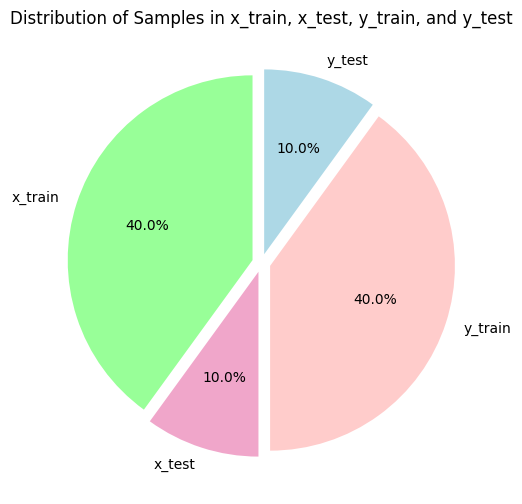

In [ ]:
num_x_train = x_train.shape[0]
num_x_test = x_test.shape[0]
num_y_train = y_train.shape[0]
num_y_test = y_test.shape[0]

# Print the number of samples in each dataset
print(f"Number of samples in x_train: {num_x_train}")
print(f"Number of samples in x_test: {num_x_test}")
print(f"Number of samples in y_train: {num_y_train}")
print(f"Number of samples in y_test: {num_y_test}")


labels = ['x_train', 'x_test', 'y_train', 'y_test']
values = [num_x_train, num_x_test, num_y_train, num_y_test]
colors = ['#98ff98', '#f0a6ca', '#ffcccb', '#add8e6']

plt.figure(figsize=(6, 6))
plt.pie(values,
        labels=labels,
        colors=colors,
        autopct='%.1f%%',
        startangle=90,
        explode=(0.05, 0.05, 0.05, 0.05))
plt.title('Distribution of Samples in x_train, x_test, y_train, and y_test')
plt.show()

# **CNN Model**


## 1. Build CNN Layers

In [ ]:
INPUT_SIZE = 64

model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), input_shape=(INPUT_SIZE, INPUT_SIZE, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for the fully connected layer
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(64))
model.add(Activation('relu'))

# Dropout Layer
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(2))
model.add(Activation('softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 2. Compile the Model

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


## 3. Train the Model & Save it

In [ ]:

# Now train the model
history = model.fit(x_train, y_train,
                    batch_size=16,
                    verbose=1,
                    epochs=10,
                    validation_split=0.2,
                    shuffle=False)


# Saving our model in my drive
model_save_path = '/content/drive/MyDrive/Brain_Tumor_Detection_MRI/brain_tumor_classification.h5'
model.save(model_save_path)


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.6673 - loss: 0.6139 - val_accuracy: 0.8267 - val_loss: 0.4158
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.8054 - loss: 0.4458 - val_accuracy: 0.8617 - val_loss: 0.3160
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.8537 - loss: 0.3332 - val_accuracy: 0.9133 - val_loss: 0.2417
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9035 - loss: 0.2449 - val_accuracy: 0.9233 - val_loss: 0.1945
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.9298 - loss: 0.1645 - val_accuracy: 0.8817 - val_loss: 0.2627
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.9675 - loss: 0.1110 - val_accuracy: 0.9450 - val_loss: 0.1655
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9753 - loss: 0.0816 - val_accuracy: 0.9733 - val_loss: 0.0911
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9841 - loss: 0.0660 -

## 4. Evaluate the model

Training Accuracy: 1.00
Test Accuracy: 0.98
Validation Accuracy: 0.98
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


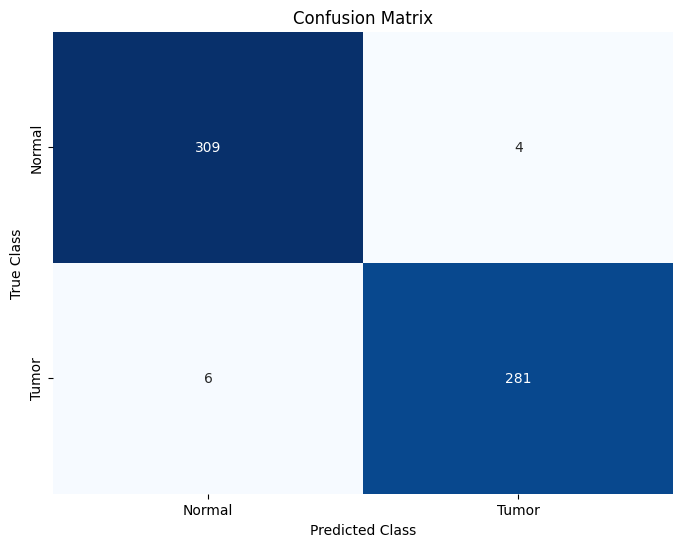

In [ ]:
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

val_accuracy = history.history['val_accuracy'][-1]
print(f'Validation Accuracy: {val_accuracy:.2f}')


# Compute confusion matrix for the CNN model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
